In [55]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
import pyproj
from matplotlib import pyplot
import rioxarray as rxr
from rasterstats import zonal_stats
import shapely

In [189]:
pd.set_option('display.max_columns', None)

In [56]:
os.chdir(r'D:\iMMAP\proj\ASDC\data\pop_admin_layer')

## Preping vector data

In [182]:
#OBS. Pop was added to admin layer prior to import
admin_path = r'D:\iMMAP\proj\ASDC\data\admin_pop.shp'
sett_path = r'D:\iMMAP\proj\ASDC\data\afg_pplp.shp'
build_path = r'D:\iMMAP\data\Afghanistan\microsoft_building_footprint.shp'
#lc_path

# Load data and convert to equal area projection
admin = gpd.read_file(admin_path).to_crs('ESRI:53034')
sett = gpd.read_file(sett_path).to_crs('ESRI:53034')
build = gpd.read_file(build_path).to_crs('ESRI:53034')
#lc = gpd.read_file(lc_path)

In [13]:
# Reproject and save land cover
#lc.set_crs('EPSG:32642').to_crs('ESRI:53034').to_file(r'input\land-cover-dis-sample-53034.shp')

In [14]:
# Load reprojected land cover
#lc = gpd.read_file(r'input\land-cover-dis-sample-53034.shp')

## Viewing vector data

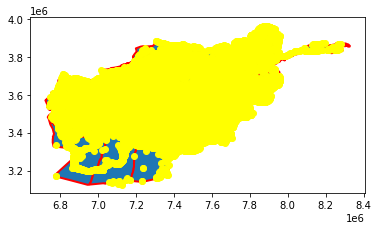

In [183]:
# View vector
ax = admin.plot(edgecolor='red', linewidth=2)
ax = sett.plot(ax=ax, color = 'yellow') #, facecolor='None', edgecolor='blue', linewidth=2)

## Area

In [184]:
# Calculating area and converting from square m to square km
admin['area_km2'] = admin['geometry'].area.div(1000000)

In [194]:
admin

,Shape_Leng,Shape_Area,ADM1_EN,ADM1_DA,ADM1_PCODE,ADM1_REF,ADM1ALT1EN,ADM1ALT2EN,ADM1ALT1DA,ADM1ALT2DA,ADM0_EN,ADM0_DA,ADM0_PCODE,date,validOn,validTo,REG_EN,REG_DA,REG_PCODE,_sum,geometry,area_km2
0,10.487964,2.085632,Ghazni,غزنی,AF11,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,South Eastern,جنوب ختیځه حوزه,SE,8.526999e+05,"POLYGON ((7571602.174 3413042.400, 7571661.953...",21552.892748
1,10.325135,3.794569,Nimroz,نیمروز,AF34,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Southern,جنوبی حوزه,SR,1.633297e+05,"POLYGON ((6955631.030 3126492.845, 6953554.537...",40301.156664
2,6.917788,0.950518,Nuristan,نورستان,AF16,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Eastern,ختیځه حوزه,ER,2.031010e+05,"POLYGON ((7916804.489 3683082.530, 7916807.736...",9579.294811
3,8.156241,1.265532,Uruzgan,ارزگان,AF25,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Southern,جنوبی حوزه,SR,4.446142e+05,"POLYGON ((7287363.719 3418361.860, 7287279.888...",13131.455369
4,2.393424,0.185458,Kapisa,کاپیسا,AF02,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Capital,مرکزی حوزه,CR,4.801654e+05,"POLYGON ((7763501.101 3636042.496, 7763432.398...",1879.207018
5,8.002717,1.810899,Paktika,پکتیکا,AF12,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,South Eastern,جنوب ختیځه حوزه,SE,4.688024e+05,"POLYGON ((7580294.669 3360579.203, 7580159.731...",18887.286113
6,4.801921,0.794449,Kunduz,کندز,AF19,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,North Eastern,سهیل ختیځه حوزه,NE,8.956564e+05,"POLYGON ((7671687.862 3787184.613, 7671417.411...",7860.632663
7,15.864174,5.749524,Hilmand,هلمند,AF30,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Southern,جنوبی حوزه,SR,1.015858e+06,"POLYGON ((7111089.461 3130141.262, 7110743.358...",60805.385864
8,9.220719,1.324432,Daykundi,دایکندی,AF24,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Central Highland,لوړه مرکزی حوزه,CH,4.398952e+05,"POLYGON ((7296497.905 3498767.221, 7296413.484...",13613.464893
9,8.211958,1.627631,Zabul,زابل,AF26,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Southern,جنوبی حوزه,SR,3.214685e+05,"POLYGON ((7537242.143 3389321.161, 7537321.987...",17030.157394


## Settlements

In [195]:
# Join settlements to admin areas
joined_df = gpd.sjoin(
    sett,
    admin,
    how='inner',
    op='intersects',
)

# Count number of settlement within admin polygons
sett_count = joined_df.groupby(
    ['ADM1_PCODE'],
    as_index=False,
)['vuid'].count() # vuid is arbitrary, we just count the rows

# Change column name to sett_count
sett_count.rename(columns = {'vuid': 'sett_count'}, inplace = True)

# QA Check - if any admin areas have no settlements
sett_count.isnull().sum()

# View results
sett_count

C:\Users\VMO\anaconda3\envs\earth2\lib\site-packages\IPython\core\interactiveshell.py:3301: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,ADM1_PCODE,sett_count
0,AF01,1028
1,AF02,631
2,AF03,1037
3,AF04,2200
4,AF05,781
5,AF06,1563
6,AF07,675
7,AF08,330
8,AF09,1571
9,AF10,1927


In [197]:
# Merge sett count back on to admin dataset
admin = admin.merge(
    sett_count, 
    on='ADM1_PCODE', 
    how='left')

admin

,Shape_Leng,Shape_Area,ADM1_EN,ADM1_DA,ADM1_PCODE,ADM1_REF,ADM1ALT1EN,ADM1ALT2EN,ADM1ALT1DA,ADM1ALT2DA,ADM0_EN,ADM0_DA,ADM0_PCODE,date,validOn,validTo,REG_EN,REG_DA,REG_PCODE,_sum,geometry,area_km2,sett_count
0,10.487964,2.085632,Ghazni,غزنی,AF11,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,South Eastern,جنوب ختیځه حوزه,SE,8.526999e+05,"POLYGON ((7571602.174 3413042.400, 7571661.953...",21552.892748,3368
1,10.325135,3.794569,Nimroz,نیمروز,AF34,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Southern,جنوبی حوزه,SR,1.633297e+05,"POLYGON ((6955631.030 3126492.845, 6953554.537...",40301.156664,628
2,6.917788,0.950518,Nuristan,نورستان,AF16,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Eastern,ختیځه حوزه,ER,2.031010e+05,"POLYGON ((7916804.489 3683082.530, 7916807.736...",9579.294811,323
3,8.156241,1.265532,Uruzgan,ارزگان,AF25,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Southern,جنوبی حوزه,SR,4.446142e+05,"POLYGON ((7287363.719 3418361.860, 7287279.888...",13131.455369,823
4,2.393424,0.185458,Kapisa,کاپیسا,AF02,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Capital,مرکزی حوزه,CR,4.801654e+05,"POLYGON ((7763501.101 3636042.496, 7763432.398...",1879.207018,631
5,8.002717,1.810899,Paktika,پکتیکا,AF12,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,South Eastern,جنوب ختیځه حوزه,SE,4.688024e+05,"POLYGON ((7580294.669 3360579.203, 7580159.731...",18887.286113,1573
6,4.801921,0.794449,Kunduz,کندز,AF19,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,North Eastern,سهیل ختیځه حوزه,NE,8.956564e+05,"POLYGON ((7671687.862 3787184.613, 7671417.411...",7860.632663,913
7,15.864174,5.749524,Hilmand,هلمند,AF30,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Southern,جنوبی حوزه,SR,1.015858e+06,"POLYGON ((7111089.461 3130141.262, 7110743.358...",60805.385864,2203
8,9.220719,1.324432,Daykundi,دایکندی,AF24,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Central Highland,لوړه مرکزی حوزه,CH,4.398952e+05,"POLYGON ((7296497.905 3498767.221, 7296413.484...",13613.464893,2074
9,8.211958,1.627631,Zabul,زابل,AF26,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Southern,جنوبی حوزه,SR,3.214685e+05,"POLYGON ((7537242.143 3389321.161, 7537321.987...",17030.157394,1678


## Buildings

In [198]:
# Convert building polygons to centroid points

# Convert building geodataframe to geoseries
build_centroids = build.geometry

# Create a geoseries with just the centroids
build_centroids = build_centroids.centroid

# Convert geoseries to geodataframe
build_centroids= gpd.GeoDataFrame(build_centroids)

# Rename column
build_centroids.rename(columns = {0: 'geo'}, inplace = True)

# Setting geometry columns specifically
build_centroids.geometry = build_centroids['geo']

In [200]:
# Join building to admin areas
joined_df = gpd.sjoin(
    build_centroids,
    admin,
    how='inner',
    op='intersects'
)

# Count number of buildings within admin polygons
build_count = joined_df.groupby(
    ['ADM1_PCODE'],
    as_index=False,
)['geo'].count() # vuid is arbitrary, we just count the rows

# Change column name to build_count
build_count.rename(columns = {'geo': 'build_count'}, inplace = True)

# QA Check - if any admin areas have no buildings
build_count.isnull().sum()

# View results
build_count

C:\Users\VMO\anaconda3\envs\earth2\lib\site-packages\IPython\core\interactiveshell.py:3301: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,ADM1_PCODE,build_count
0,AF01,643926
1,AF02,67797
2,AF03,105118
3,AF04,104831
4,AF05,83454
5,AF06,343146
6,AF07,87840
7,AF08,18741
8,AF09,219387
9,AF10,53604


In [201]:
# Merge build count back on to admin dataset
admin = admin.merge(
    build_count, 
    on='ADM1_PCODE', 
    how='left')

## Population Density

In [207]:
# Rename pop column
admin.rename(columns={'_sum':'pop_sum'}, inplace=True)

,Shape_Leng,Shape_Area,ADM1_EN,ADM1_DA,ADM1_PCODE,ADM1_REF,ADM1ALT1EN,ADM1ALT2EN,ADM1ALT1DA,ADM1ALT2DA,ADM0_EN,ADM0_DA,ADM0_PCODE,date,validOn,validTo,REG_EN,REG_DA,REG_PCODE,pop_sum,geometry,area_km2,sett_count,build_count
0,10.487964,2.085632,Ghazni,غزنی,AF11,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,South Eastern,جنوب ختیځه حوزه,SE,8.526999e+05,"POLYGON ((7571602.174 3413042.400, 7571661.953...",21552.892748,3368,236035
1,10.325135,3.794569,Nimroz,نیمروز,AF34,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Southern,جنوبی حوزه,SR,1.633297e+05,"POLYGON ((6955631.030 3126492.845, 6953554.537...",40301.156664,628,79747
2,6.917788,0.950518,Nuristan,نورستان,AF16,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Eastern,ختیځه حوزه,ER,2.031010e+05,"POLYGON ((7916804.489 3683082.530, 7916807.736...",9579.294811,323,6208
3,8.156241,1.265532,Uruzgan,ارزگان,AF25,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Southern,جنوبی حوزه,SR,4.446142e+05,"POLYGON ((7287363.719 3418361.860, 7287279.888...",13131.455369,823,124085
4,2.393424,0.185458,Kapisa,کاپیسا,AF02,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Capital,مرکزی حوزه,CR,4.801654e+05,"POLYGON ((7763501.101 3636042.496, 7763432.398...",1879.207018,631,67797
5,8.002717,1.810899,Paktika,پکتیکا,AF12,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,South Eastern,جنوب ختیځه حوزه,SE,4.688024e+05,"POLYGON ((7580294.669 3360579.203, 7580159.731...",18887.286113,1573,111126
6,4.801921,0.794449,Kunduz,کندز,AF19,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,North Eastern,سهیل ختیځه حوزه,NE,8.956564e+05,"POLYGON ((7671687.862 3787184.613, 7671417.411...",7860.632663,913,289473
7,15.864174,5.749524,Hilmand,هلمند,AF30,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Southern,جنوبی حوزه,SR,1.015858e+06,"POLYGON ((7111089.461 3130141.262, 7110743.358...",60805.385864,2203,505723
8,9.220719,1.324432,Daykundi,دایکندی,AF24,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Central Highland,لوړه مرکزی حوزه,CH,4.398952e+05,"POLYGON ((7296497.905 3498767.221, 7296413.484...",13613.464893,2074,88234
9,8.211958,1.627631,Zabul,زابل,AF26,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Southern,جنوبی حوزه,SR,3.214685e+05,"POLYGON ((7537242.143 3389321.161, 7537321.987...",17030.157394,1678,90411


In [208]:
# Rename pop column
admin.rename(columns={'_sum': 'pop_sum'})
#df.rename(columns={"A": "a", "B": "c"})

# Calculate population density
admin['pop_density'] = admin['pop_sum'] / admin['area_km2']

# Calculate people per building
admin['people_building'] = admin['pop_sum'] / admin['build_count']

admin

,Shape_Leng,Shape_Area,ADM1_EN,ADM1_DA,ADM1_PCODE,ADM1_REF,ADM1ALT1EN,ADM1ALT2EN,ADM1ALT1DA,ADM1ALT2DA,ADM0_EN,ADM0_DA,ADM0_PCODE,date,validOn,validTo,REG_EN,REG_DA,REG_PCODE,pop_sum,geometry,area_km2,sett_count,build_count,pop_density,people_building
0,10.487964,2.085632,Ghazni,غزنی,AF11,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,South Eastern,جنوب ختیځه حوزه,SE,8.526999e+05,"POLYGON ((7571602.174 3413042.400, 7571661.953...",21552.892748,3368,236035,39.563131,3.612599
1,10.325135,3.794569,Nimroz,نیمروز,AF34,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Southern,جنوبی حوزه,SR,1.633297e+05,"POLYGON ((6955631.030 3126492.845, 6953554.537...",40301.156664,628,79747,4.052731,2.048099
2,6.917788,0.950518,Nuristan,نورستان,AF16,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Eastern,ختیځه حوزه,ER,2.031010e+05,"POLYGON ((7916804.489 3683082.530, 7916807.736...",9579.294811,323,6208,21.202083,32.716012
3,8.156241,1.265532,Uruzgan,ارزگان,AF25,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Southern,جنوبی حوزه,SR,4.446142e+05,"POLYGON ((7287363.719 3418361.860, 7287279.888...",13131.455369,823,124085,33.858711,3.583142
4,2.393424,0.185458,Kapisa,کاپیسا,AF02,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Capital,مرکزی حوزه,CR,4.801654e+05,"POLYGON ((7763501.101 3636042.496, 7763432.398...",1879.207018,631,67797,255.514898,7.082399
5,8.002717,1.810899,Paktika,پکتیکا,AF12,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,South Eastern,جنوب ختیځه حوزه,SE,4.688024e+05,"POLYGON ((7580294.669 3360579.203, 7580159.731...",18887.286113,1573,111126,24.821058,4.218657
6,4.801921,0.794449,Kunduz,کندز,AF19,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,North Eastern,سهیل ختیځه حوزه,NE,8.956564e+05,"POLYGON ((7671687.862 3787184.613, 7671417.411...",7860.632663,913,289473,113.942026,3.094093
7,15.864174,5.749524,Hilmand,هلمند,AF30,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Southern,جنوبی حوزه,SR,1.015858e+06,"POLYGON ((7111089.461 3130141.262, 7110743.358...",60805.385864,2203,505723,16.706704,2.008723
8,9.220719,1.324432,Daykundi,دایکندی,AF24,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Central Highland,لوړه مرکزی حوزه,CH,4.398952e+05,"POLYGON ((7296497.905 3498767.221, 7296413.484...",13613.464893,2074,88234,32.313243,4.985552
9,8.211958,1.627631,Zabul,زابل,AF26,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Southern,جنوبی حوزه,SR,3.214685e+05,"POLYGON ((7537242.143 3389321.161, 7537321.987...",17030.157394,1678,90411,18.876425,3.555635


## Export results

In [211]:
admin.to_crs('EPSG:4326').to_file(r'output/pop_adm_full.shp')

C:\Users\VMO\AppData\Local\Temp\ipykernel_2716\2904481836.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  admin.to_crs('EPSG:4326').to_file(r'output/pop_adm_full.shp')
